In [33]:
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START

In [34]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


In [36]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive","negative"] = Field("Sentiment of the review")

In [68]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [69]:
structured_llm = llm.with_structured_output(SentimentSchema)
structured_llm2 = llm.with_structured_output(DiagnosisSchema)

In [71]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive","negative"]
    response: str
    diagnosis: dict

In [73]:
def find_setiment(state:ReviewState):

    prompt = f"Find the sentiment of the following review: \n {state["review"]}"
    sentiment = structured_llm.invoke(prompt).sentiment
    return {"sentiment":sentiment}

def check_sentiment(state:ReviewState)-> Literal["positive_response","run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"
    
def positive_response(state:ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    response = llm.invoke(prompt).content
    return {"response":response}

def run_diagnosis(state:ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_llm2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = llm.invoke(prompt).content

    return {'response': response}


In [75]:
graph = StateGraph(ReviewState)

graph.add_node("find_setiment",find_setiment)
graph.add_node("positive_response",positive_response)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("negative_response",negative_response)


graph.add_conditional_edges("find_setiment",check_sentiment)
graph.add_edge("positive_response",END)
graph.add_edge("run_diagnosis","negative_response")
graph.add_edge("negative_response",END)

workflow = graph.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

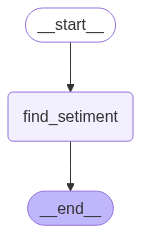

In [61]:
workflow

In [64]:
initial_state = {"review":"product is good"}
final_state = workflow.invoke(initial_state)
final_state

{'review': 'product is good', 'sentiment': 'positive'}